# QuTiP example: Floquet formalism for dynamics and steadystates

J.R. Johansson and P.D. Nation

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt

In [7]:
import numpy as np

In [8]:
from qutip import *
import time

## Floquet modes and quasi energies

Find the floquet modes and quasi energies for a driven system and plot the floquet states/quasienergies for one period of the driving.


In [13]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args['H0']
    H1 = args['H1']
    w  = args['w']

    return H0 + sin(w * t) * H1

def H1_coeff_t(t, args):
    return sin(args['w'] * t)

In [14]:
def qubit_integrate(delta, eps0_vec, A, omega, gamma1, gamma2, psi0, T, option):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    # collapse operators
    c_op_list = []

    n_th = 0.0 # zero temperature

    # relaxation
    rate = gamma1 * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)

    # excitation
    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())

    # dephasing 
    rate = gamma2
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)


    quasi_energies = np.zeros((len(eps0_vec), 2))
    f_gnd_prob     = np.zeros((len(eps0_vec), 2))
    wf_gnd_prob    = np.zeros((len(eps0_vec), 2))

    for idx, eps0 in enumerate(eps0_vec):

        H0 = - delta/2.0 * sx - eps0/2.0 * sz
        H1 = A/2.0 * sz
       
        # H = H0 + H1 * sin(w * t) in the 'list-string' format
        H = [H0, [H1, 'sin(w * t)']]
        Hargs = {'w': omega}
            
        # find the floquet modes
        f_modes,f_energies = floquet_modes(H, T, Hargs)

        quasi_energies[idx,:] = f_energies

        f_gnd_prob[idx, 0] = expect(sm.dag() * sm, f_modes[0])
        f_gnd_prob[idx, 1] = expect(sm.dag() * sm, f_modes[1])

        f_states = floquet_states_t(f_modes, f_energies, 0, H, T, Hargs)

        wf_gnd_prob[idx, 0] = expect(sm.dag() * sm, f_states[0])
        wf_gnd_prob[idx, 1] = expect(sm.dag() * sm, f_states[1])
        
    return quasi_energies, f_gnd_prob, wf_gnd_prob

In [15]:
delta = 0.2 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 0.5 * 2 * np.pi  # qubit sigma_z coefficient
gamma1 = 0.0        # relaxation rate
gamma2 = 0.0         # dephasing  rate
A      = 2.0 * 2 * np.pi 
psi0   = basis(2,0)    # initial state
omega  = 1.0 * 2 * np.pi # driving frequency
T      = (2*np.pi)/omega  # driving period

param  = np.linspace(-5.0, 5.0, 200) * 2 * np.pi 

eps0 = param

In [23]:
# very slow?
start_time = time.time()
q_energies, f_gnd_prob, wf_gnd_prob = qubit_integrate(delta, eps0, A, omega, gamma1, gamma2, psi0, T, "dynamics")
print('dynamics: time elapsed = ' + str(time.time() - start_time))

TypeError: qubit_integrate() takes 6 positional arguments but 9 were given

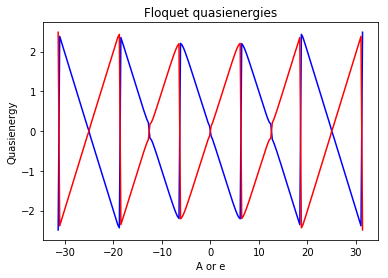

In [9]:
fig, ax = plt.subplots()
ax.plot(param, np.real(q_energies[:,0]) / delta, 'b',
        param, np.real(q_energies[:,1]) / delta, 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Quasienergy')
ax.set_title('Floquet quasienergies');

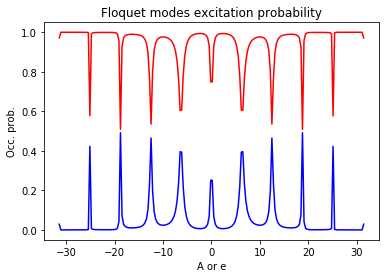

In [10]:
fig, ax = plt.subplots()
ax.plot(param, np.real(f_gnd_prob[:,0]), 'b', 
        param, np.real(f_gnd_prob[:,1]), 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob.')
ax.set_title('Floquet modes excitation probability');

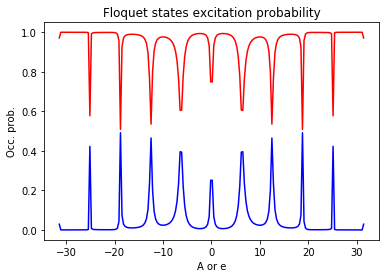

In [11]:
fig, ax = plt.subplots()
ax.plot(param, np.real(wf_gnd_prob[:,0]), 'b',
        param, np.real(wf_gnd_prob[:,1]), 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob.')
ax.set_title('Floquet states excitation probability');

## Floquet modes

In [17]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]
    w  = args[2]

    return H0 + cos(w * t) * H1

def H1coeff_t(t, args):
    w  = args['w']
    return sin(w * t)           

In [18]:

def qubit_integrate(delta, eps0, A, omega, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 =   A/2.0 * sz
        
    #H_args = (H0, H1, omega)
    H_args = {'w': omega}
    H = [H0, [H1, 'sin(w * t)']]
    #H = [H0, [H1, H1coeff_t]]
    
    # find the propagator for one driving period
    T = 2*np.pi / omega
       
    f_modes_0,f_energies = floquet_modes(H, T, H_args)

    p_ex_0 = np.zeros(shape(tlist))
    p_ex_1 = np.zeros(shape(tlist))

    p_00 = np.zeros(shape(tlist), dtype=complex)
    p_01 = np.zeros(shape(tlist), dtype=complex)    
    p_10 = np.zeros(shape(tlist), dtype=complex)
    p_11 = np.zeros(shape(tlist), dtype=complex)    
    
    e_0 = np.zeros(shape(tlist))
    e_1 = np.zeros(shape(tlist))
         
    f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, H_args) 

    for idx, t in enumerate(tlist):
        #f_modes_t = floquet_modes_t(f_modes_0, f_energies, t, H, T, H_args) 
        f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T) 

        p_ex_0[idx] = expect(sm.dag() * sm, f_modes_t[0])
        p_ex_1[idx] = expect(sm.dag() * sm, f_modes_t[1])

        p_00[idx] = f_modes_t[0].full()[0][0]
        p_01[idx] = f_modes_t[0].full()[1][0]
        p_10[idx] = f_modes_t[1].full()[0][0]
        p_11[idx] = f_modes_t[1].full()[1][0]

        #evals = hamiltonian_t(t, H_args).eigenenergies()
        evals = qobj_list_evaluate(H, t, H_args).eigenenergies()
        e_0[idx] = min(np.real(evals))
        e_1[idx] = max(np.real(evals))
        
    return p_ex_0, p_ex_1, e_0, e_1, f_energies, p_00, p_01, p_10, p_11

In [19]:
delta = 0.2 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi  # qubit sigma_z coefficient
A     = 2.5 * 2 * np.pi  # sweep rate
psi0   = basis(2,0)   # initial state
omega  = 1.0 * 2 * np.pi # driving frequency
T      = (2*np.pi)/omega # driving period

tlist = np.linspace(0.0, T, 101)

In [20]:
start_time = time.time()
p_ex_0, p_ex_1, e_0, e_1, f_e, p_00, p_01, p_10, p_11 = qubit_integrate(delta, eps0, A, omega, psi0, tlist)
print('dynamics: time elapsed = ' + str(time.time() - start_time))

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221221.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


dynamics: time elapsed = 9.297245502471924


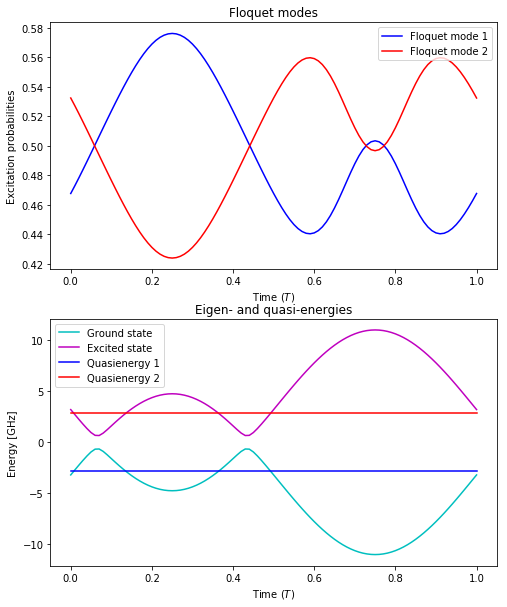

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[8,10])

ax1.plot(tlist, np.real(p_ex_0), 'b', tlist, np.real(p_ex_1), 'r')
ax1.set_xlabel('Time ($T$)')
ax1.set_ylabel('Excitation probabilities')
ax1.set_title('Floquet modes')
ax1.legend(("Floquet mode 1", "Floquet mode 2"))

ax2.plot(tlist, np.real(e_0), 'c', tlist, np.real(e_1), 'm')
ax2.plot(tlist, np.ones(shape(tlist)) * f_e[0], 'b', tlist, np.ones(shape(tlist)) * f_e[1], 'r')
ax2.set_xlabel('Time ($T$)')
ax2.set_ylabel('Energy [GHz]')
ax2.set_title('Eigen- and quasi-energies')
ax2.legend(("Ground state", "Excited state", "Quasienergy 1", "Quasienergy 2"));

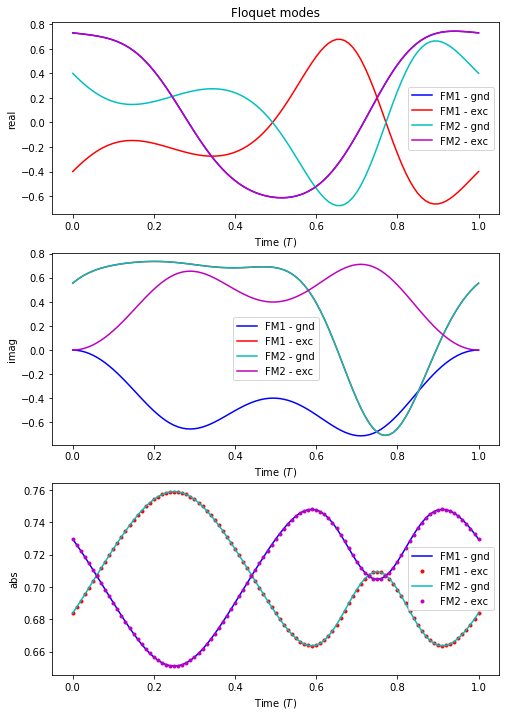

In [22]:
fig, axes = plt.subplots(3, 1, figsize=[8,12])

axes[0].plot(tlist, np.real(p_00), 'b', tlist, np.real(p_01), 'r')
axes[0].plot(tlist, np.real(p_10), 'c', tlist, np.real(p_11), 'm')
axes[0].set_xlabel('Time ($T$)')
axes[0].set_ylabel('real')
axes[0].set_title('Floquet modes')
axes[0].legend(("FM1 - gnd", "FM1 - exc", "FM2 - gnd", "FM2 - exc"))

axes[1].plot(tlist, np.imag(p_00), 'b', tlist, np.imag(p_01), 'r')
axes[1].plot(tlist, np.imag(p_10), 'c', tlist, np.imag(p_11), 'm')
axes[1].set_xlabel('Time ($T$)')
axes[1].set_ylabel('imag')
axes[1].legend(("FM1 - gnd", "FM1 - exc", "FM2 - gnd", "FM2 - exc"))

axes[2].plot(tlist, abs(p_00), 'b', tlist, abs(p_01), 'r.')
axes[2].plot(tlist, abs(p_10), 'c', tlist, abs(p_11), 'm.')
axes[2].set_xlabel('Time ($T$)')
axes[2].set_ylabel('abs')
axes[2].legend(("FM1 - gnd", "FM1 - exc", "FM2 - gnd", "FM2 - exc"));

## Floquet evolution

Find the floquet modes and quasi energies for a driven system and evolve the wavefunction "stroboscopically", i.e., only by evaluating at time mupliples of the driving period t = n * T for integer n.

The system is a strongly driven two-level atom.


In [24]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]
    w  = args[2]
    return H0 + np.sin(w * t) * H1
    
def H1coeff_t(t, args):
    w  = args['w']
    return np.sin(w * t)

In [25]:
def qubit_integrate(delta, eps0, A, omega, psi0, tlist, T, option):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 =   A/2.0 * sz        
    #H_args = (H0, H1, omega)
    H_args = {'w': omega}
    H = [H0, [H1, 'sin(w * t)']]
    #H = [H0, [H1, H1coeff_t]]  
    

    if option == "floquet":

        # find the floquet modes for the time-dependent hamiltonian        
        f_modes_0,f_energies = floquet_modes(H, T, H_args)

        # decompose the inital state in the floquet modes (=floquet states at t=0)
        f_coeff = floquet_state_decomposition(f_modes_0, f_energies, psi0)

                    
        # only evaluate the wavefunction at multiples of the driving period
        # i.e. a "stroboscopic" evolution
        N = int(round(max(tlist)/T))
        p_ex = np.zeros(N)                    
        tlist = []
        
        # calculate the wavefunctions at times t=nT, for integer n, by using 
        # the floquet modes and quasienergies
        for n in np.arange(N):            
            psi_t = floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, n*T, H, T, H_args)            
            p_ex[n] = expect(sm.dag() * sm, psi_t)
            tlist.append(n*T)   
    
    else:
    
        # for reference: evolve and calculate expectation using the full ode solver
        #H_args = (H0, H1, omega)
        #expt_list = mesolve(hamiltonian_t, psi0, tlist, [], [sm.dag() * sm], H_args)
        output = mesolve(H, psi0, tlist, [], [sm.dag() * sm], H_args)
        p_ex = output.expect[0]
        
    return tlist, p_ex

In [26]:
delta = 0.2 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 0.1 * 2 * np.pi  # qubit sigma_z coefficient
A     = 1.0 * 2 * np.pi  # driving amplitude
psi0   = basis(2,0)      # initial state
omega  = 1.0 * 2 * np.pi # driving frequency

T      = (2*np.pi)/omega # driving period
tlist  = np.linspace(0.0, 25 * T, 500)

In [27]:
start_time = time.time()
tlist1, p_ex = qubit_integrate(delta, eps0, A, omega, psi0, tlist, T, "dynamics")
print('dynamics: time elapsed = ' + str(time.time() - start_time))

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221222.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


dynamics: time elapsed = 9.242259979248047


In [28]:
start_time = time.time()
tlist2, f_ex = qubit_integrate(delta, eps0, A, omega, psi0, tlist, T, "floquet")
print('floquet: time elapsed = ' + str(time.time() - start_time))

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221223.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


floquet: time elapsed = 8.5344717502594


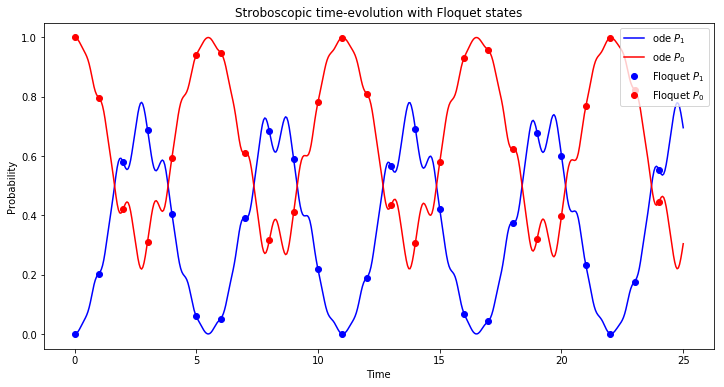

In [29]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.plot(tlist1, np.real(p_ex),   'b')
ax.plot(tlist1, np.real(1-p_ex), 'r')
ax.plot(tlist2, np.real(f_ex),   'bo', linewidth=2.0)
ax.plot(tlist2, np.real(1-f_ex), 'ro', linewidth=2.0)

ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.set_title('Stroboscopic time-evolution with Floquet states')
ax.legend(("ode $P_1$", "ode $P_0$", "Floquet $P_1$", "Floquet $P_0$"));

## Floquet-Markov master equation: comparison with other solvers

In [30]:
gamma1 = 0.0015          # relaxation rate
gamma2 = 0.0           # dephasing  rate

def J_cb(omega):
    """ Noise spectral density """
    #print "evaluate J_cb for omega =", omega
    return 0.5 * gamma1 * omega/(2*np.pi)
    
def H1_coeff_t(t, args):
    return np.sin(args['w'] * t)

In [31]:
def qubit_integrate(delta, eps0, A, w, gamma1, gamma2, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 = - A * sx

    args = {'w': w}
    H = [H0, [H1, 'sin(w * t)']]


    # --------------------------------------------------------------------------
    # 1) time-dependent hamiltonian
    # 
    #    
    c_op_list = [np.sqrt(gamma1) * sx, np.sqrt(gamma2) * sz]

    start_time = time.time()
    output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], args=args)      
    expt_list1 = output.expect
    print('Method 1: time elapsed = ' + str(time.time() - start_time))

    # --------------------------------------------------------------------------
    # 2) Constant hamiltonian
    #
    H_rwa = - delta/2.0 * sx - A * sx / 2
    c_op_list = [np.sqrt(gamma1) * sx, np.sqrt(gamma2) * sz]
    
    start_time = time.time()
    output = mesolve(H_rwa, psi0, tlist, c_op_list, [sm.dag() * sm])  
    expt_list2 = output.expect
    print('Method 2: time elapsed = ' + str(time.time() - start_time))


    # --------------------------------------------------------------------------
    # 3) Floquet unitary evolution
    #
    qutip.solver.config.reset()
    
    start_time = time.time()
       
    T = 2*np.pi / w       
    f_modes_0,f_energies = floquet_modes(H, T, args)    
    
    # decompose the initial state vector in terms of the floquet modes (basis
    # transformation). used to calculate psi_t below.
    f_coeff = floquet_state_decomposition(f_modes_0, f_energies, psi0)
    
    # --------------------------------------------------------------------------
    # 4) Floquet markov master equation dynamics
    #       
    kmax = 1
    temp = 25e-3
    w_th = temp * (1.38e-23 / 6.626e-34) * 2 * np.pi * 1e-9   
    
    f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, np.linspace(0, T, 500+1), H, T, args) 
    
    # calculate the rate-matrices for the floquet-markov master equation
    Delta, X, Gamma, Amat = floquet_master_equation_rates(f_modes_0, f_energies, sx, 
                                                          H, T, args, J_cb, w_th, kmax, f_modes_table_t)
   
    # the floquet-markov master equation tensor
    R = floquet_master_equation_tensor(Amat, f_energies)
    
    rho_list = floquet_markov_mesolve(R, f_modes_0, psi0, tlist, []).states

    expt_list3 = np.zeros(shape(expt_list2), dtype=complex)
    expt_list4 = np.zeros(shape(expt_list2), dtype=complex)
    for idx, t in enumerate(tlist):            
    
        # unitary floquet evolution
        psi_t = floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, T, args)            
        expt_list3[0][idx] = expect(sm.dag() * sm, psi_t) 
        
        # the rho_list returned by the floquet master equation is defined in the
        # floquet basis, so to transform it back to the computational basis
        # before we calculate expectation values.
        #f_modes_t = floquet_modes_t(f_modes_0, f_energies, t, H, T, args)
        f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T) 
        expt_list4[0][idx] = expect((sm.dag() * sm), rho_list[idx].transform(f_modes_t, True)) 
    
    print('Method 3+4: time elapsed = ' + str(time.time() - start_time))

    # calculate the steadystate density matrix according to the floquet-markov
    # master equation
    rho_ss_fb = floquet_master_equation_steadystate(H0, Amat) # in floquet basis
    rho_ss_cb = rho_ss_fb.transform(f_modes_0, True)         # in computational basis
    expt_list5 = np.ones(np.shape(expt_list2), dtype=complex) * expect(sm.dag() * sm, rho_ss_cb)
    
    return expt_list1[0], expt_list2[0], expt_list3[0], expt_list4[0], expt_list5[0]

In [32]:
delta = 0.0 * 2 * np.pi   # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A     = 0.05 * 2 * np.pi  # driving amplitude (reduce to make the RWA more accurate)
w     = 1.0 * 2 * np.pi   # driving frequency
psi0 = (0.3*basis(2,0) + 0.7*basis(2,1)).unit()      # initial state

tlist = np.linspace(0, 30.0, 500)

In [33]:
# executed in 1h 28m 40s, finished 16:11:29 2019-05-21? something is wrong?
p_ex1, p_ex2, p_ex3, p_ex4, p_ex5 = qubit_integrate(delta, eps0, A, w, gamma1, gamma2, psi0, tlist)

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221224.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Method 1: time elapsed = 9.408191442489624
Method 2: time elapsed = 0.021119117736816406


/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221225.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221226.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221227.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221251.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221252.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221253.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221277.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221278.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221279.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221303.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221304.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221305.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221329.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221330.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221331.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221355.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221356.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221357.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221381.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221382.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221383.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221407.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221408.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221409.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221433.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221434.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221435.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221459.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221460.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221461.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221485.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221486.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221487.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221511.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221512.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221513.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221537.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221538.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221539.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221563.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221564.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221565.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221589.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221590.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221591.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221615.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221616.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221617.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221641.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221642.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221643.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

SystemExit: 1

NameError: name 'p_ex1' is not defined

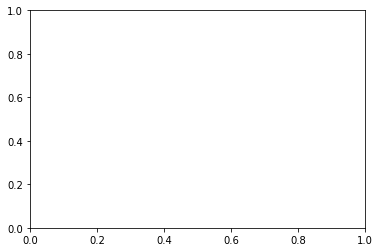

In [34]:
fig, ax = plt.subplots()
ax.plot(tlist, np.real(p_ex1), 'b', tlist, np.real(p_ex2), 'g-') # lindblad
ax.plot(tlist, np.real(p_ex3), 'r', tlist, np.real(p_ex4), 'm-', tlist, np.real(p_ex5), 'c-') # floquet markov
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Comparison between time-dependent master equations')
ax.legend(("TD Hamiltonian, Std ME", "RWA Hamiltonian, Std ME", 
        "Unitary Floquet evol.", "Floquet-Markov ME", "F-M ME steady state"));

## Floquet-Markov master equation

In [35]:
def J_cb(omega):
    """ Noise spectral density """
    return omega
    
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]
    w  = args[2]

    return H0 + np.cos(w * t) * H1

In [36]:
def qubit_integrate(delta, eps0, A, omega, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 =   A/2.0 * sz
        
    #H_args = (H0, H1, omega)
    H_args = {'w': omega}
    H = [H0, [H1, 'sin(w * t)']]
    
    # find the propagator for one driving period
    T = 2*np.pi / omega
       
    f_modes_0,f_energies = floquet_modes(H, T, H_args)

    c_op = sigmax()

    kmax = 1

    temp = 25e-3
    w_th = temp * (1.38e-23 / 6.626e-34) * 2 * np.pi * 1e-9
    
    Delta, X, Gamma, A = floquet_master_equation_rates(f_modes_0, f_energies, c_op, H, T, H_args, J_cb, w_th, kmax)

    k_idx = 0
    for k in range(-kmax,kmax+1, 1):
        print("X[",k,"] =\n", X[:,:,k_idx])
        k_idx += 1

    k_idx = 0
    for k in range(-kmax,kmax+1, 1):
        print("Delta[",k,"] =\n", Delta[:,:,k_idx])
        k_idx += 1

    k_idx = 0
    for k in range(-kmax,kmax+1, 1):
        print("Gamma[",k,"] =\n", Gamma[:,:,k_idx])
        k_idx += 1
        
    print("A =\n", A)

    rho_ss = floquet_master_equation_steadystate(H0, A)
    
    
    R = floquet_master_equation_tensor(A, f_energies)
    
    print("Floquet-Markov master equation tensor")
    
    print("R =\n", R)
    
    print("Floquet-Markov master equation steady state =\n", rho_ss)

    p_ex_0 = np.zeros(shape(tlist))
    p_ex_1 = np.zeros(shape(tlist))
    
    e_0 = np.zeros(shape(tlist))
    e_1 = np.zeros(shape(tlist))
        
    f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, H_args) 
    for idx, t in enumerate(tlist):
        f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T) 

        p_ex_0[idx] = expect(sm.dag() * sm, f_modes_t[0])
        p_ex_1[idx] = expect(sm.dag() * sm, f_modes_t[1])

        #evals = hamiltonian_t(t, H_args).eigenenergies()
        evals = qobj_list_evaluate(H, t, H_args).eigenenergies()
        e_0[idx] = min(np.real(evals))
        e_1[idx] = max(np.real(evals))
        
    return p_ex_0, p_ex_1, e_0, e_1, f_energies

In [37]:
delta = 0.2 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi  # qubit sigma_z coefficient
A     = 2.5 * 2 * np.pi  # sweep rate
psi0   = basis(2,0)      # initial state
omega  = 1.0 * 2 * np.pi # driving frequency
T      = (2*np.pi)/omega # driving period

tlist = np.linspace(0.0, 1 * T, 101)

In [38]:
# executed in 17.3s, finished 16:12:10 2019-05-21
start_time = time.time()
p_ex_0, p_ex_1, e_0, e_1, f_e = qubit_integrate(delta, eps0, A, omega, psi0, tlist)
print('dynamics: time elapsed = ' + str(time.time() - start_time))

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221647.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


X[ -1 ] =
 [[-9.28812386e-07-0.19524686j  2.02821572e-01+0.31089129j]
 [-1.22745895e-03+0.00188092j  9.28812387e-07+0.19524686j]]
X[ 0 ] =
 [[-0.48721742+0.j          0.26340702-0.17184238j]
 [ 0.26340702+0.17184238j  0.48721742+0.j        ]]
X[ 1 ] =
 [[-9.28812386e-07+0.19524686j -1.22745895e-03-0.00188092j]
 [ 2.02821572e-01-0.31089129j  9.28812387e-07-0.19524686j]]
Delta[ -1 ] =
 [[ -6.28318531 -11.94580952]
 [ -0.62056109  -6.28318531]]
Delta[ 0 ] =
 [[ 0.         -5.66262422]
 [ 5.66262422  0.        ]]
Delta[ 1 ] =
 [[ 6.28318531  0.62056109]
 [11.94580952  6.28318531]]
Gamma[ -1 ] =
 [[-0. -0.]
 [-0. -0.]]
Gamma[ 0 ] =
 [[ 0.         -0.        ]
 [ 3.51925918  0.        ]]
Gamma[ 1 ] =
 [[1.50497004e+00 1.96690651e-05]
 [1.03422040e+01 1.50497004e+00]]
A =
 [[ 2.0217056   1.03320703]
 [14.89465051  2.0217056 ]]
Floquet-Markov master equation tensor
R =
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-14.89465051+0.j          

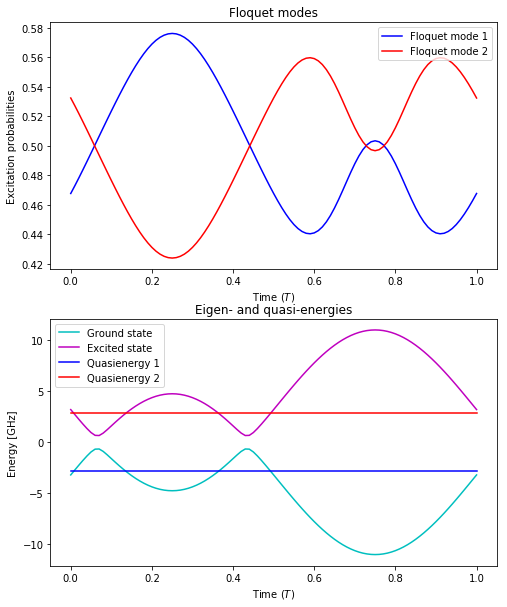

In [39]:
fig, axes = plt.subplots(2, 1, figsize=[8,10])

axes[0].plot(tlist, np.real(p_ex_0), 'b', tlist, np.real(p_ex_1), 'r')
axes[0].set_xlabel('Time ($T$)')
axes[0].set_ylabel('Excitation probabilities')
axes[0].set_title('Floquet modes')
axes[0].legend(("Floquet mode 1", "Floquet mode 2"))

axes[1].plot(tlist, np.real(e_0), 'c', tlist, np.real(e_1), 'm')
axes[1].plot(tlist, np.ones_like(tlist) * f_e[0], 'b', tlist, np.ones_like(tlist) * f_e[1], 'r')
axes[1].set_xlabel('Time ($T$)')
axes[1].set_ylabel('Energy [GHz]')
axes[1].set_title('Eigen- and quasi-energies')
axes[1].legend(("Ground state", "Excited state", "Quasienergy 1", "Quasienergy 2"));

## Steadystate

In [41]:
def J_cb(omega):
    """ Noise spectral density """
    return omega
    
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args['H0']
    H1 = args['H1']
    w  = args['w']

    return H0 + np.sin(w * t) * H1

def H1_coeff_t(t, args):
    return np.sin(args['w'] * t)

In [42]:
def qubit_integrate(delta, eps0_vec, A, omega, gamma1, gamma2, psi0, T, option):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    quasi_energies = np.zeros((len(eps0_vec), 2))
    f_gnd_prob     = np.zeros((len(eps0_vec), 2))
    wf_gnd_prob    = np.zeros((len(eps0_vec), 2))
    ss_prob1       = np.zeros(len(eps0_vec))
    ss_prob2       = np.zeros(len(eps0_vec))

    Hargs = {'w': omega}

    for idx, eps0 in enumerate(eps0_vec):

        H0 = - delta/2.0 * sx - eps0/2.0 * sz
        H1 = A/2.0 * sz
        H = [H0, [H1, 'sin(w * t)']]
            
        f_modes,f_energies = floquet_modes(H, T, Hargs)

        quasi_energies[idx,:] = f_energies

        f_gnd_prob[idx, 0] = expect(sm.dag() * sm, f_modes[0])
        f_gnd_prob[idx, 1] = expect(sm.dag() * sm, f_modes[1])

        f_states = floquet_states_t(f_modes, f_energies, 0, H, T, Hargs)

        wf_gnd_prob[idx, 0] = expect(sm.dag() * sm, f_states[0])
        wf_gnd_prob[idx, 1] = expect(sm.dag() * sm, f_states[1])

        c_op = sigmax()
        kmax = 5
        temp = 0e-3
        w_th = temp * (1.38e-23 / 6.626e-34) * 2 * np.pi * 1e-9    
        Delta, X, Gamma, Amat = floquet_master_equation_rates(f_modes, f_energies, c_op, H, T, Hargs, J_cb, w_th, kmax)

        rho_ss_fb = floquet_master_equation_steadystate(H0, Amat) # floquet basis
        rho_ss_cb = rho_ss_fb.transform(f_modes, True) #False           # computational basis
        
        ss_prob1[idx] = expect(sm.dag() * sm, rho_ss_fb)
        ss_prob2[idx] = expect(sm.dag() * sm, rho_ss_cb)

    return quasi_energies, f_gnd_prob, wf_gnd_prob, ss_prob1, ss_prob2

In [43]:
delta = 0.1 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi  # qubit sigma_z coefficient
gamma1 = 0.0             # relaxation rate
gamma2 = 0.0             # dephasing  rate
A      = 2.0 * 2 * np.pi 
psi0   = basis(2,0)    # initial state
omega  = np.sqrt(delta**2 + eps0**2) # driving frequency
T      = (2*np.pi)/omega  # driving period

param  = np.linspace(-2.0, 2.0, 100) * 2 * np.pi 

eps0 = param

In [44]:
# slow!
# executed in 29m 56s, finished 17:13:10 2019-05-21
start_time = time.time()
q_energies, f_gnd_prob, wf_gnd_prob, ss_prob1, ss_prob2 = qubit_integrate(delta, eps0, A, omega, 
                                                                          gamma1, gamma2, psi0, T, "dynamics")
print('dynamics: time elapsed = ' + str(time.time() - start_time))
# executed in 29m 56s, finished 17:13:10 2019-05-21

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221648.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221649.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221650.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221674.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221675.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221676.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221700.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221701.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221702.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221726.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221727.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/qhx11/Documents/qutip-notebooks/examples/rhs221728.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/bub/miniconda3/lib/python3.7

dynamics: time elapsed = 1795.7111430168152


Text(0.5, 1.0, 'Floquet quasienergies')

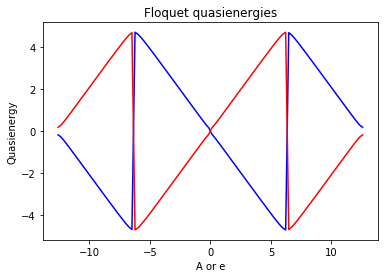

In [45]:
fig, ax = plt.subplots()
ax.plot(param, np.real(q_energies[:,0]) / delta, 'b',
        param, np.real(q_energies[:,1]) / delta, 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Quasienergy')
ax.set_title('Floquet quasienergies')

Text(0.5, 1.0, 'Floquet modes excitation probability')

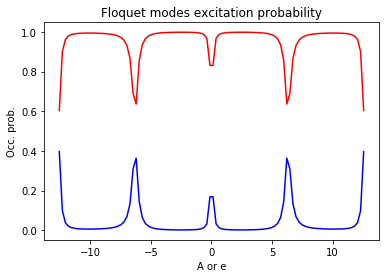

In [46]:
fig, ax = plt.subplots()
ax.plot(param, np.real(f_gnd_prob[:,0]), 'b',
        param, np.real(f_gnd_prob[:,1]), 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob.')
ax.set_title('Floquet modes excitation probability')

Text(0.5, 1.0, 'Floquet states excitation probability')

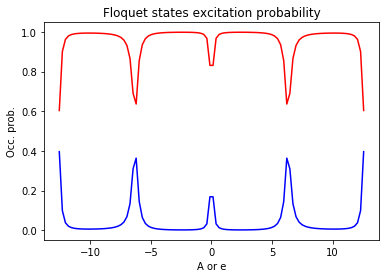

In [47]:
fig, ax = plt.subplots()
ax.plot(param, np.real(wf_gnd_prob[:,0]), 'b',
        param, np.real(wf_gnd_prob[:,1]), 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob.')
ax.set_title('Floquet states excitation probability')

Text(0.5, 1.0, 'Steady state excitation probability')

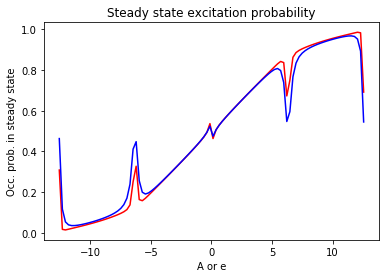

In [48]:
fig, ax = plt.subplots()
ax.plot(param, np.real(ss_prob1), 'r')
ax.plot(param, np.real(ss_prob2), 'b')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob. in steady state')
ax.set_title('Steady state excitation probability')

## Versions

In [40]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.1
Numpy,1.15.4
SciPy,1.2.1
matplotlib,3.0.2
Cython,0.29.7
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.2.0
Python,"3.7.1 (default, Dec 14 2018, 19:28:38) [GCC 7.3.0]"
OS,posix [linux]
